# ORENIST Classification Example

Note: This notebook is desinged to run with Python3 and CPU (no GPU) runtime.<br>

Modified for local (off-line) mode with Python 3.x, TensorFlow 1.x (or 2.x), with or without GPU<br>
2020/02/04: By H.Nishiyama<br>

This notebook rewrite for local (off-line) TensorFlow 1.x (or 2.x).<br>
*If you use on online-colaboratory system, remove "###" from the top of lines in code cells. <br>
Original notebook uses TensorFlow 2.x.

In [1]:
###%tensorflow_version 2.x

####[OCE-01]
Import modules and set random seeds.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
import pickle

import tensorflow as tf
from tensorflow.keras import layers, models

np.random.seed(20190823)

#--- For TensorFlow 1.x, use the following line, but if you use TensorFlow2.x, you need to comment it out..
tf.random.set_random_seed(20190823)
#--- For TensorFlow 2.x, use following line, instead of upper line.
###tf.random.set_seed(20190823)

####[OCE-02]
Download the ORENIST dataset and store into NumPy arrays.

In [3]:
###!curl -LO https://github.com/enakai00/colab_tfbook/raw/master/Chapter04/ORENIST.data
with open('ORENIST.data', 'rb') as file:
    images, labels = pickle.load(file)

####[OCE-03]
Define fixed convolutional filters to extract vertical and horizontal edges.

In [4]:
def edge_filter(shape=None, dtype=None):
    filter0 = np.array(
            [[ 2, 1, 0,-1,-2],
             [ 3, 2, 0,-2,-3],
             [ 4, 3, 0,-3,-4],
             [ 3, 2, 0,-2,-3],
             [ 2, 1, 0,-1,-2]]) / 23.0
    filter1 = np.array(
            [[ 2, 3, 4, 3, 2],
             [ 1, 2, 3, 2, 1],
             [ 0, 0, 0, 0, 0],
             [-1,-2,-3,-2,-1],
             [-2,-3,-4,-3,-2]]) / 23.0
    
    filter_array = np.zeros([5, 5, 1, 2])
    filter_array[:, :, 0, 0] = filter0
    filter_array[:, :, 0, 1] = filter1

    return filter_array

####[OCE-04]
Define a model to classify the ORENIST dataset with the fixed filters.

In [5]:
model = models.Sequential()
model.add(layers.Reshape((28, 28, 1), input_shape=(28*28,), name='reshape'))
model.add(layers.Conv2D(2, (5, 5), padding='same',
                        kernel_initializer=edge_filter,
                        use_bias=False, trainable=False,
                        name='conv_filter'))
model.add(layers.Lambda(lambda x: abs(x), name='abs'))
model.add(layers.Lambda(lambda x: tf.keras.backend.relu(x-0.2), name='cut_off'))
model.add(layers.MaxPooling2D((2, 2), name='max_pooling'))

model.add(layers.Flatten(name='flatten'))
model.add(layers.Dense(2, activation='tanh', name='hidden'))
model.add(layers.Dense(3, activation='softmax', name='softmax'))
                       
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv_filter (Conv2D)         (None, 28, 28, 2)         50        
_________________________________________________________________
abs (Lambda)                 (None, 28, 28, 2)         0         
_________________________________________________________________
cut_off (Lambda)             (None, 28, 28, 2)         0         
_________________________________________________________________
max_pooling (MaxPooling2D)   (None, 14, 14, 2)         0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________

####[OCE-05]
Compile the model using the Adam optimizer, and Cross entroy as a loss function.

In [6]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['acc'])

####[OCE-06]
Train the model.

In [7]:
history = model.fit(images, labels,
                    batch_size=len(images), epochs=200, verbose=0)

####[OCE-07]
Plot a chart to see the accuracy of the model. It achieves the 100% accuracy.

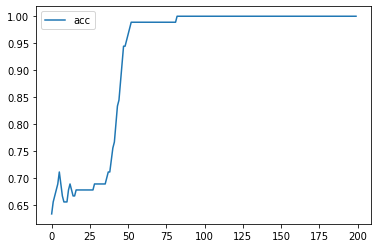

In [8]:
DataFrame({'acc': history.history['acc']}).plot()

####[OCE-08]
Define a model to extract outputs from the hidden layer.

In [9]:
layer_outputs = [model.get_layer('hidden').output]
model2 = models.Model(inputs=model.input, outputs=layer_outputs)

####[OCE-09]
Plot a chart to show the values of $(z_1, z_2)$ for each image.

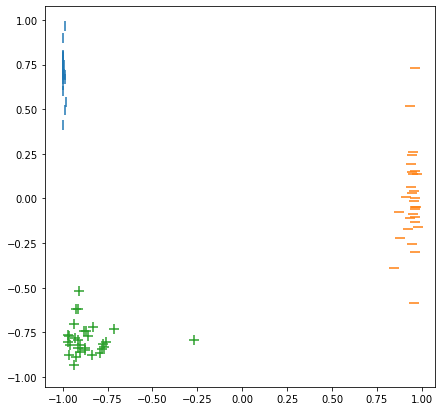

In [10]:
hidden_vals = model2.predict(images)

z1_vals = [[],[],[]]
z2_vals = [[],[],[]]

for hidden_val, label in zip(hidden_vals, labels):
    label_num = np.argmax(label)
    z1_vals[label_num].append(hidden_val[0])
    z2_vals[label_num].append(hidden_val[1])
    
fig = plt.figure(figsize=(7, 7))
subplot = fig.add_subplot(1, 1, 1)
subplot.scatter(z1_vals[0], z2_vals[0], s=100, marker='|')
subplot.scatter(z1_vals[1], z2_vals[1], s=100, marker='_')
subplot.scatter(z1_vals[2], z2_vals[2], s=100, marker='+')